# yearly plot of the monthly chlor image from 2D data using the GlobColour dataset

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
# resampling frequency in number of days
#freq=2

In [3]:
from tools.load_GlobColor_dataset import load_dataset
import importlib
importlib.reload(load_dataset)

<module 'tools.load_GlobColor_dataset.load_dataset' from '/Users/vyan2000/work_linux/2Archive/myproject/20161024xray_oceancolor/ocean_color-master/tools/load_GlobColor_dataset/load_dataset.py'>

100%|██████████| 5538/5538 [01:11<00:00, 77.55it/s]


<xarray.Dataset>
Dimensions:    (lat: 553, lon: 721, time: 5538)
Coordinates:
  * lat        (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon        (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time       (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...
Data variables:
    CHL1_mean  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.4
    title:                      GlobColour daily merged MERIS/SeaWiFS product
    product_name:               L3m_20020428__665648402_4_AVW-MERSWF_CHL1_DAY...
    product_type:               day
    product_version:            2016.1
    product_level:              3
    parameter_code:             CHL1
    parameter:                  Chlorophyll concentration
    parameter_algo_list:        ,
    publication:                O'Reilly, J.E., and 24 Coauthors, 2000: SeaWi...
    site_name:                  665648402
    sensor_name:   

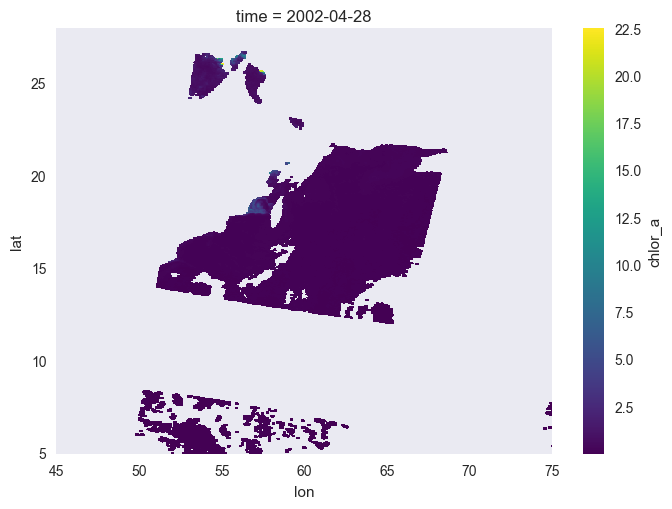

In [5]:
############### CHL1
ds_daily = load_dataset.load_chl1()
ds_daily.chlor_a.sel(time='2002-04-28').plot()

In [6]:
freq_resample = str(8) + 'D'
ds_8day = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_8day

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 695)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-04-28 2002-05-06 2002-05-14 ...
Data variables:
    chlor_a  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

In [7]:
# check data quality
both_datasets = [ds_8day, ds_daily]
print([(ds.nbytes / 1e6) for ds in both_datasets])

[2216.854936, 17664.630152]


In [8]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [9]:
[fix_bad_data(ds) for ds in both_datasets]

[None, None]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


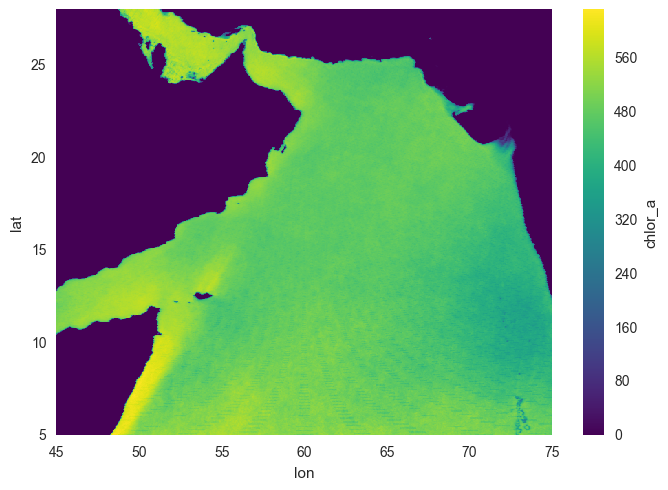

In [10]:
# Count the number of ocean data points
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


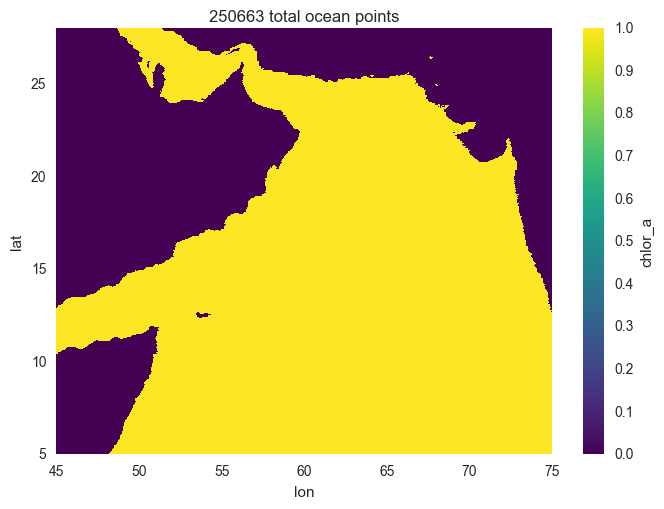

In [11]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


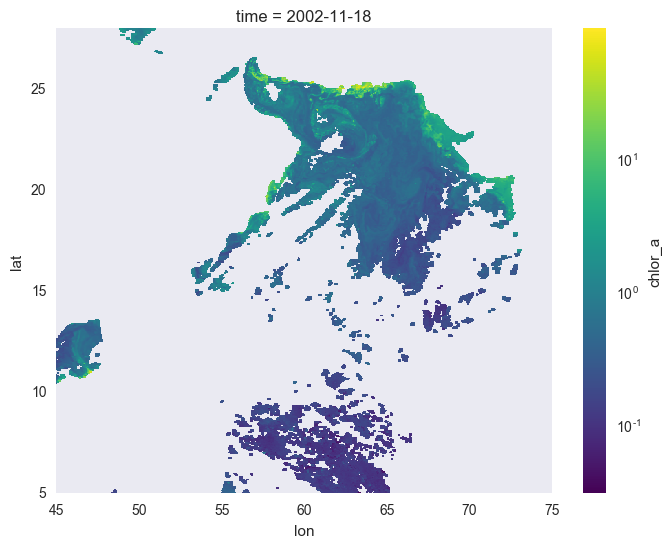

In [12]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())

In [13]:
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5538)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...
Data variables:
    chlor_a  (time) int64 62260 52391 58822 43103 37195 55773 25428 19652 ...

In [14]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5538)>
array([ 0.248381,  0.20901 ,  0.234666, ...,  0.003495,  0.020705,  0.034552])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...

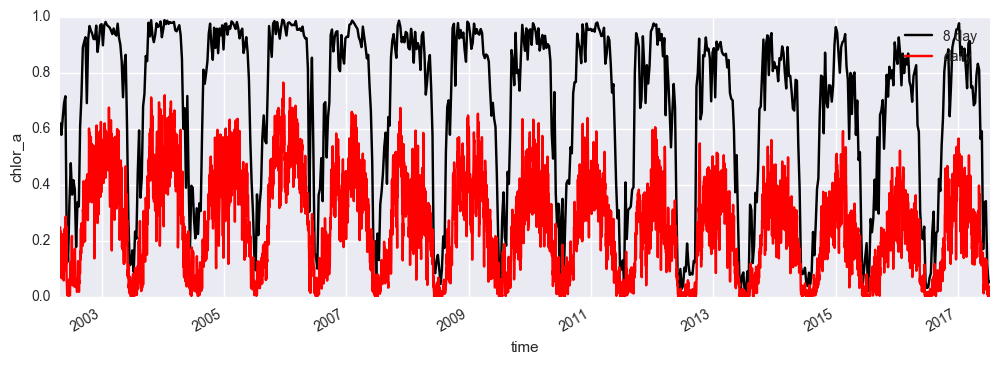

In [15]:
count_8day,count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

# Seasonal Climatology

In [16]:
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()  # monthly data
                                      for count in (count_8day, count_daily)]

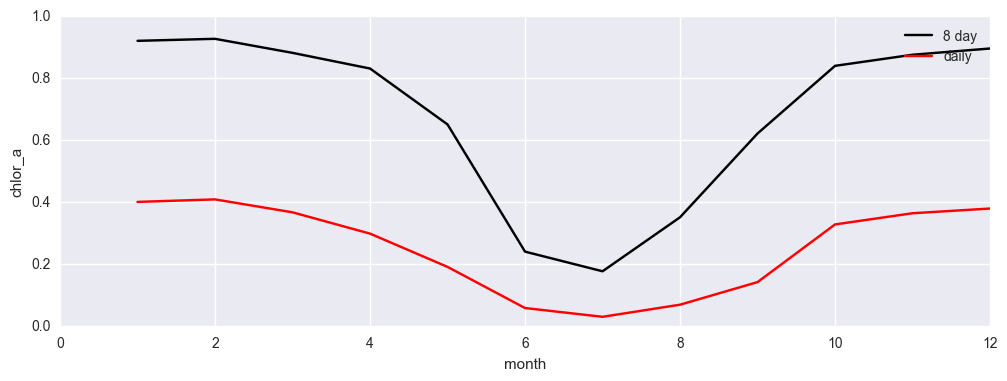

In [17]:
# mean value of the monthly data on the count of nonzeros
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

From the above figure, we see that data coverage is highest in the winter (especially Feburary) and lowest in summer.

# Maps of individual days
Let's grab some data from Febrauary and plot it.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


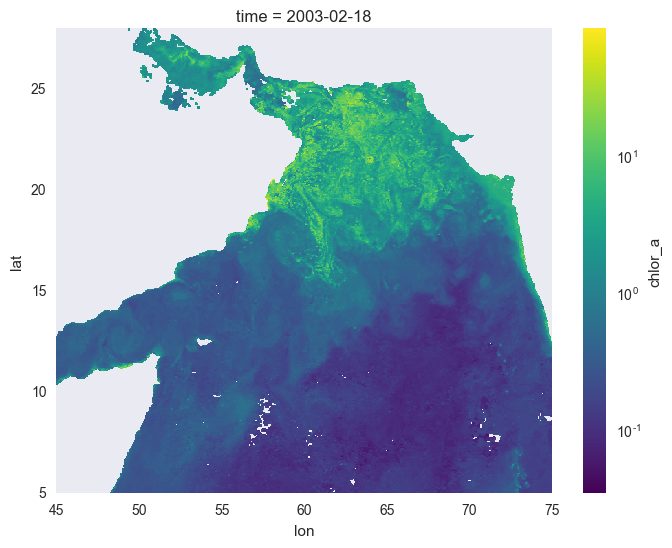

In [18]:
# Maps of individual days
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


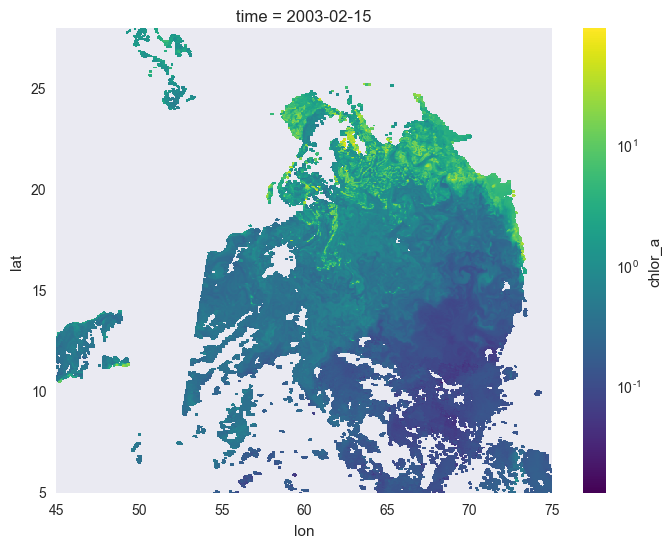

In [19]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

# Monthly resample starting from here

In [20]:
freq_resample = 'M'   # resampling using month end
print("resampling frequency is ", freq_resample)
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

resampling frequency is  M


<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 184)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-04-30 2002-05-31 2002-06-30 ...
Data variables:
    chlor_a  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

In [21]:

# http://xarray.pydata.org/en/stable/time-series.html
# key: xarray 
'''
print(ds_resample['time.month'])
print(ds_resample['time.year'])
print(ds_resample['time.year']==2002)
'''

"\nprint(ds_resample['time.month'])\nprint(ds_resample['time.year'])\nprint(ds_resample['time.year']==2002)\n"

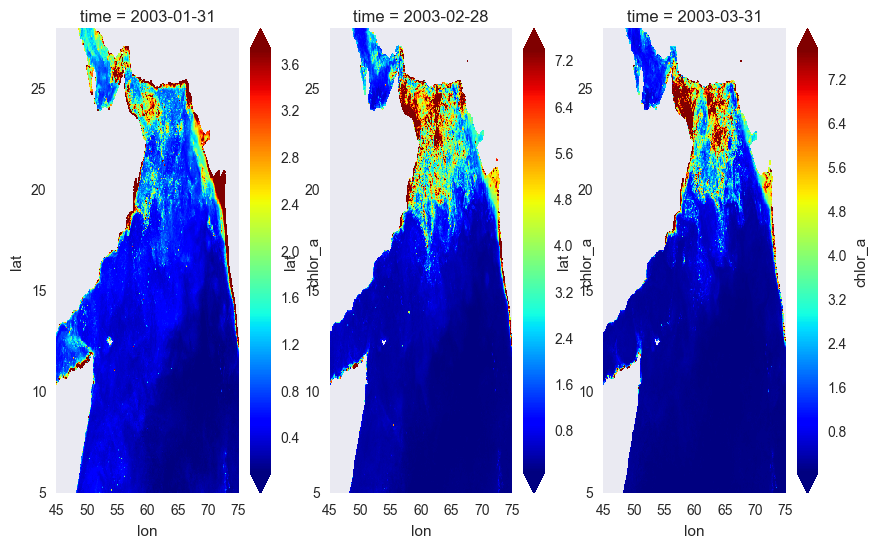

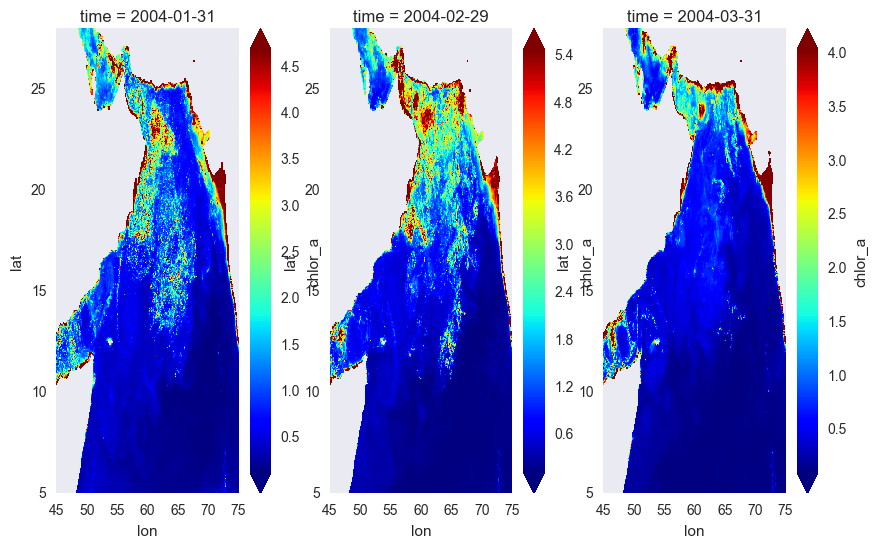

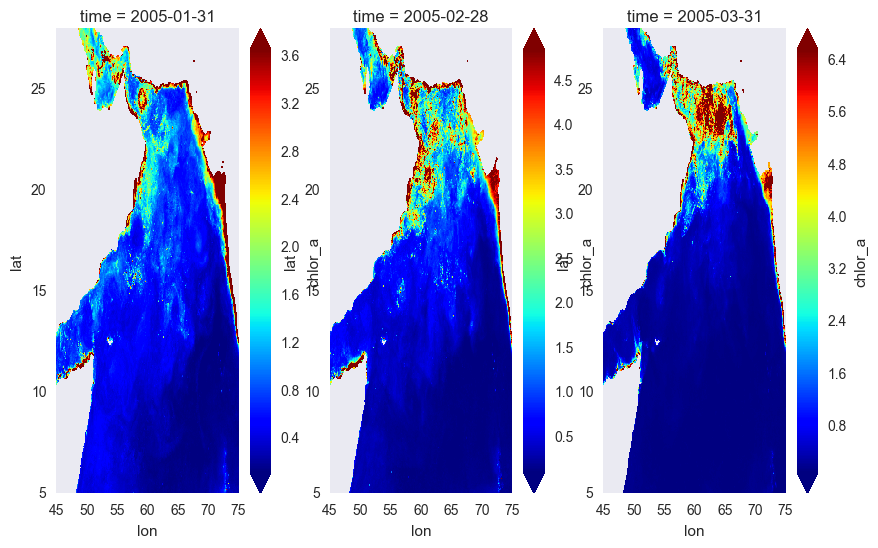

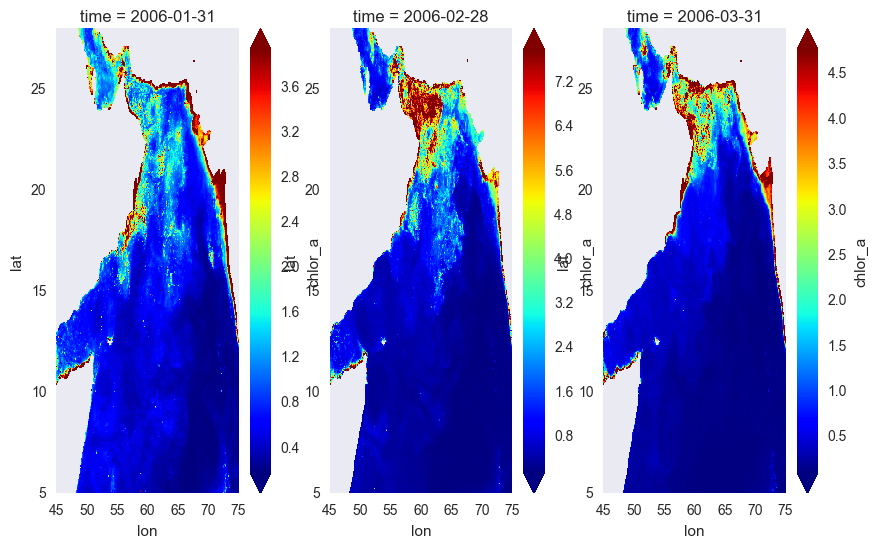

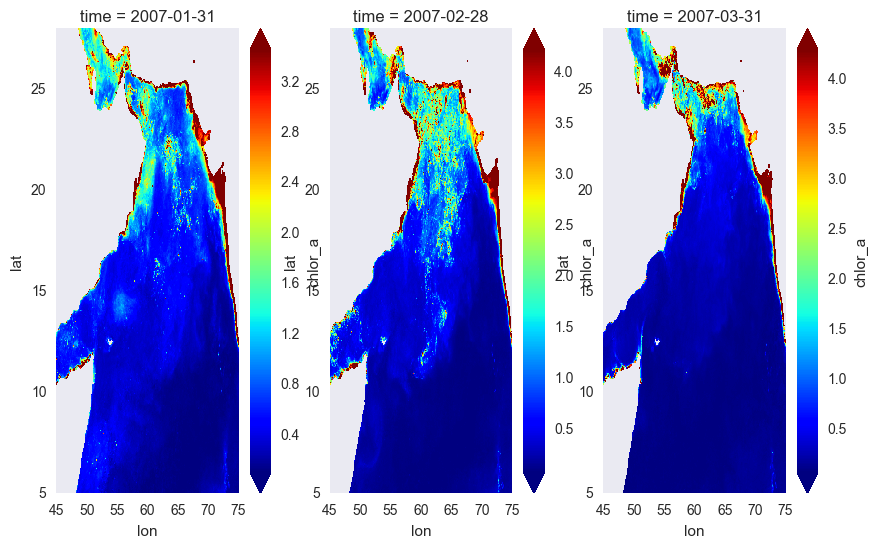

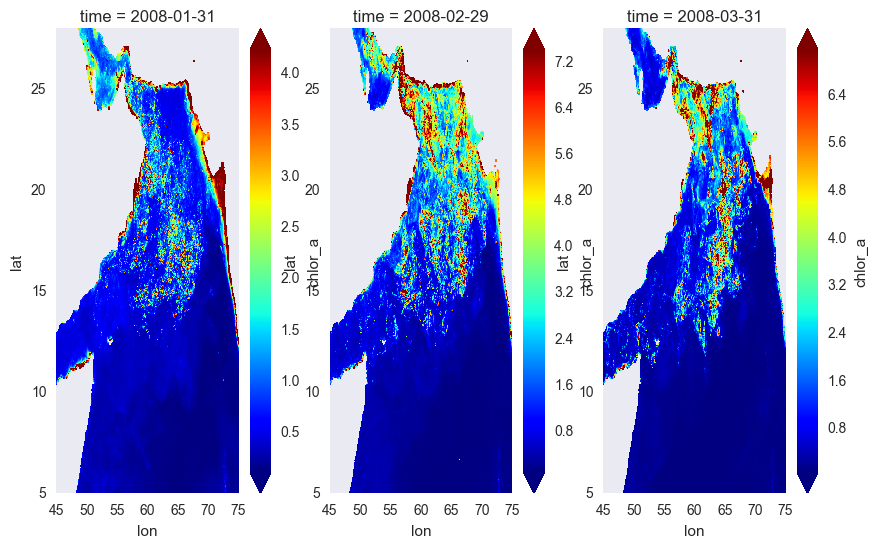

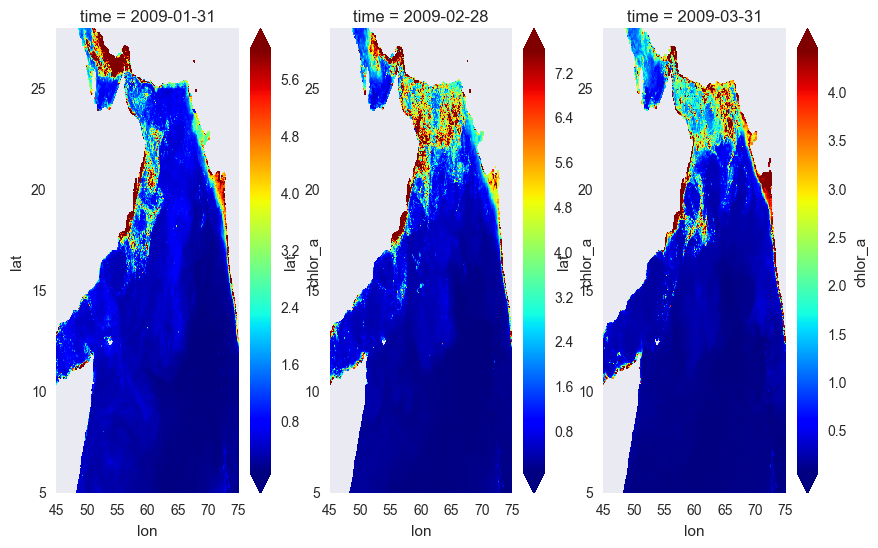

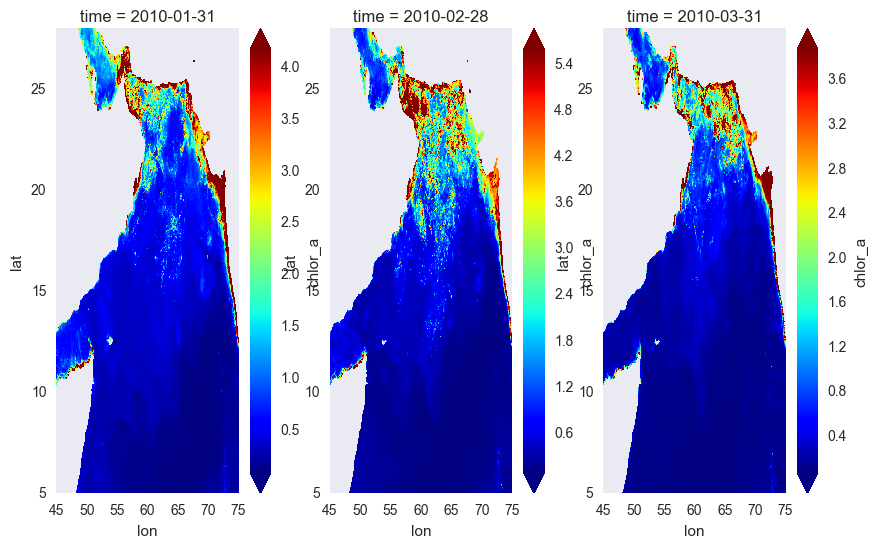

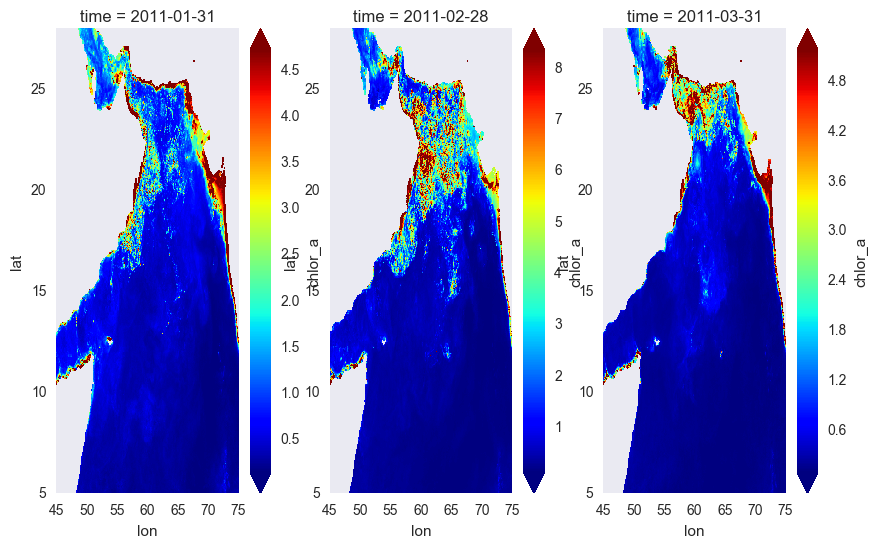

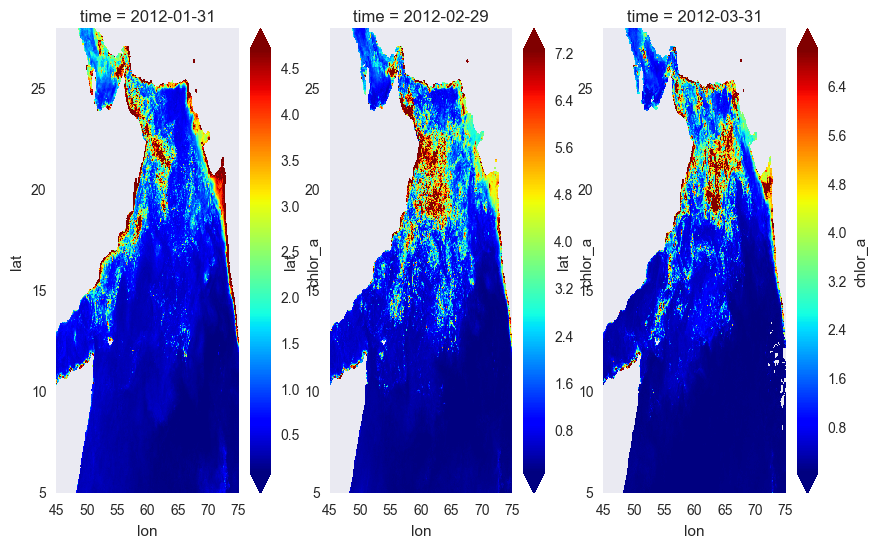

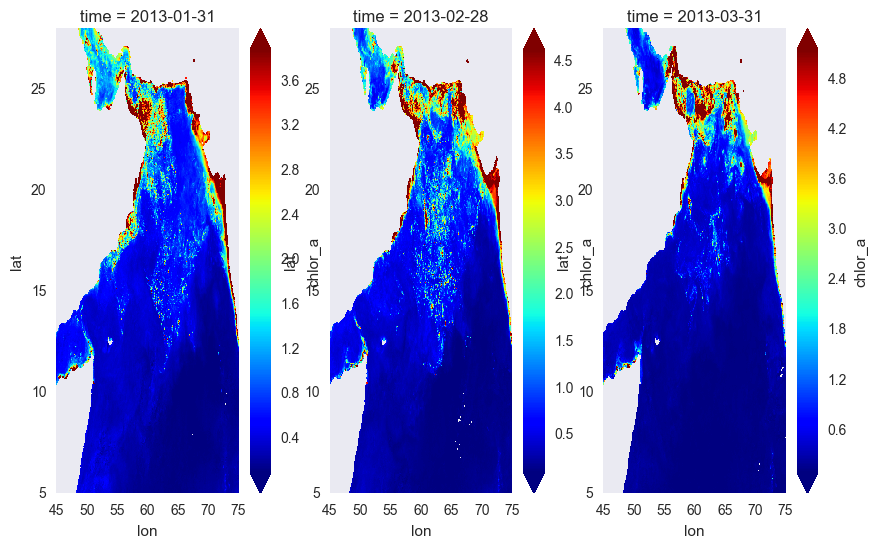

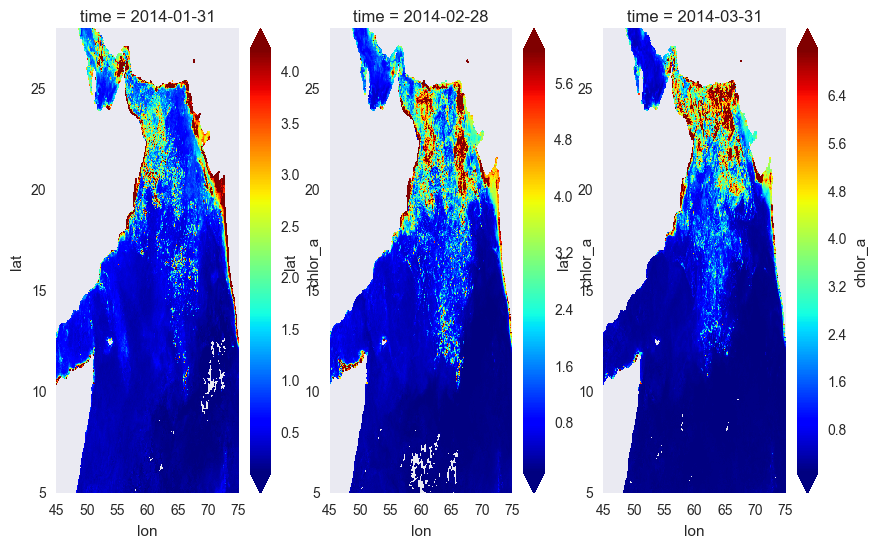

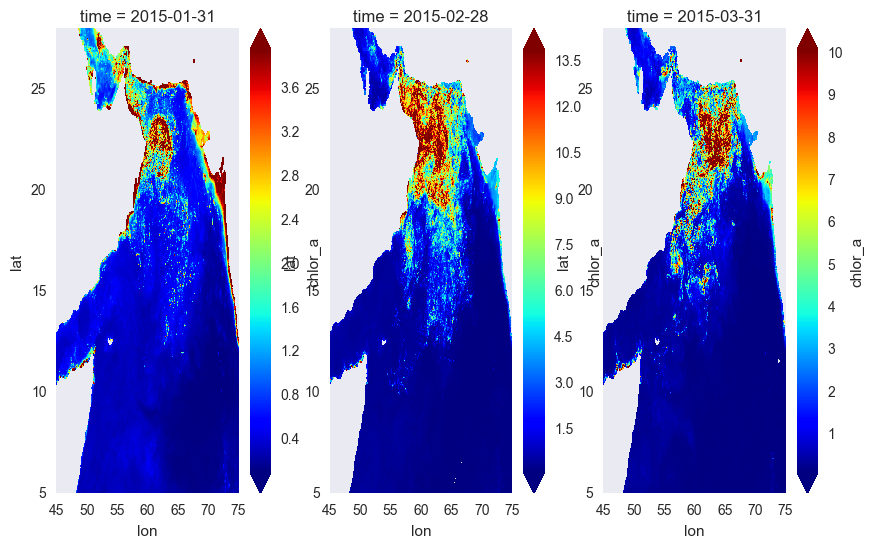

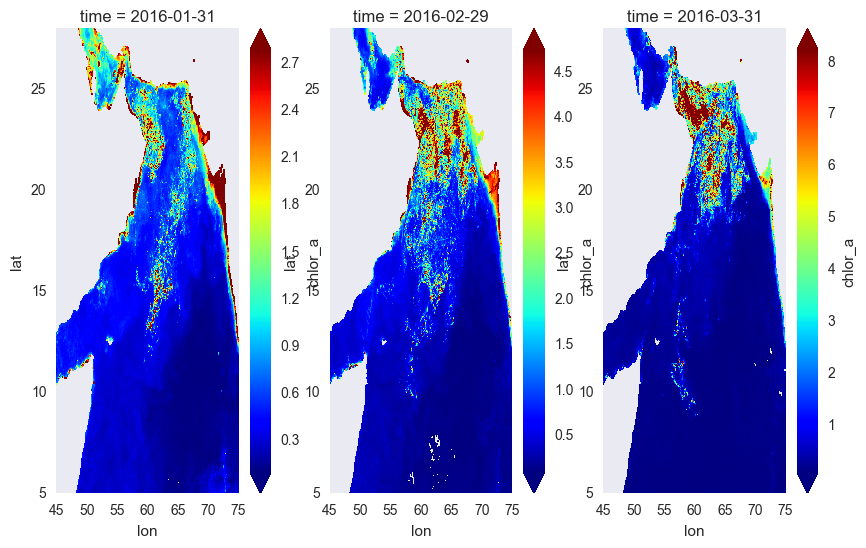

In [22]:

### Approach 1
### gather the data, and plot
### norm=LogNorm() removed
### use robust (outlier not considered)
### hard to remove cmap

for year in range(2003, 2017):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
    
    for month in range(1,4):
        plt.subplot(130+month)
        time_target = str(year) + "-0" + str(month)
        im = ds_resample.chlor_a.sel(time=time_target,  method='nearest').plot(robust=True, cmap="jet") 

    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
    #fig.colorbar(im, cax=cbar_ax, )

    plt.show()
    plt.close()

[numpy.datetime64('2016-02'), numpy.datetime64('2016-03'), numpy.datetime64('2016-04')]


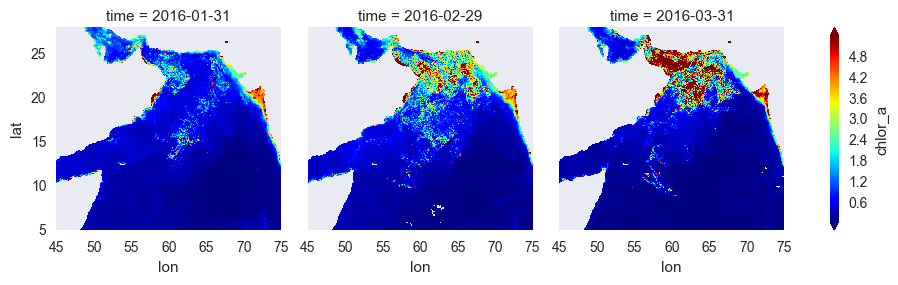

In [23]:
##### some tests ####
time_target = [np.datetime64(str(year) + '-02'), np.datetime64(str(year) + '-03'), np.datetime64(str(year) + '-04')]
print(time_target)
ds_resample.chlor_a.sel(time= list(time_target),  method='nearest').plot(x='lon', y='lat', col='time',  cmap="jet",  robust=True, col_wrap=3)


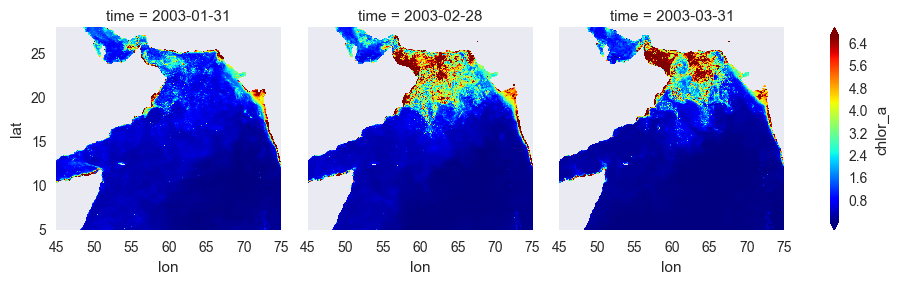

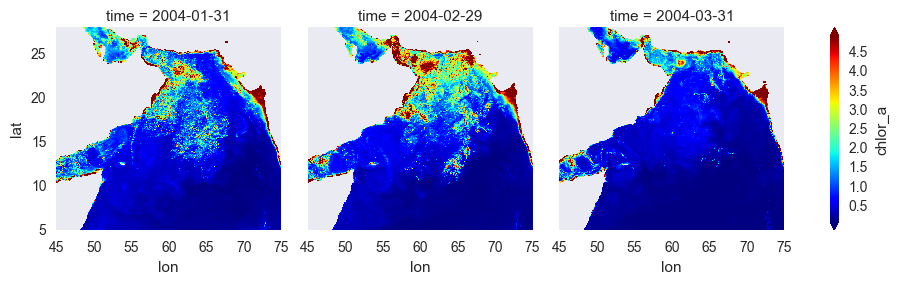

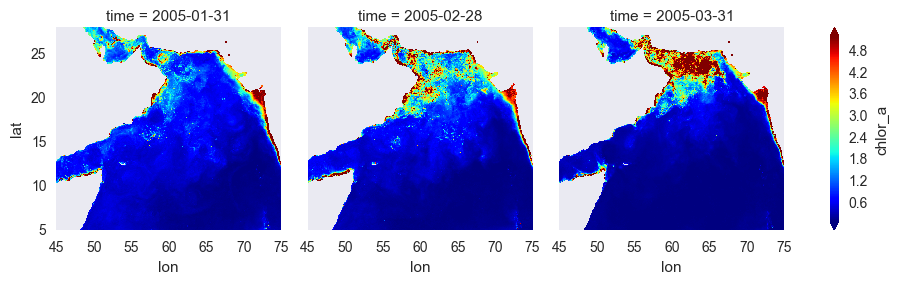

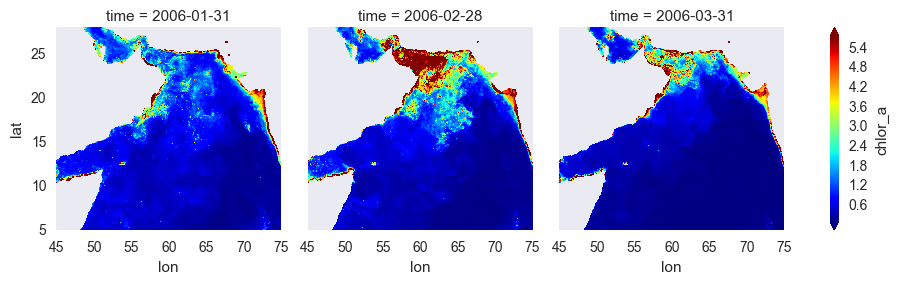

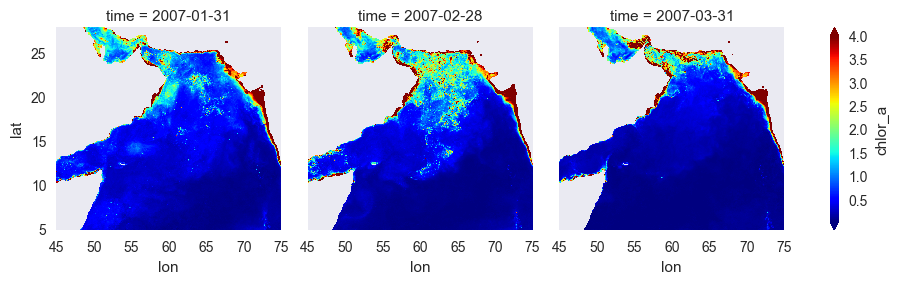

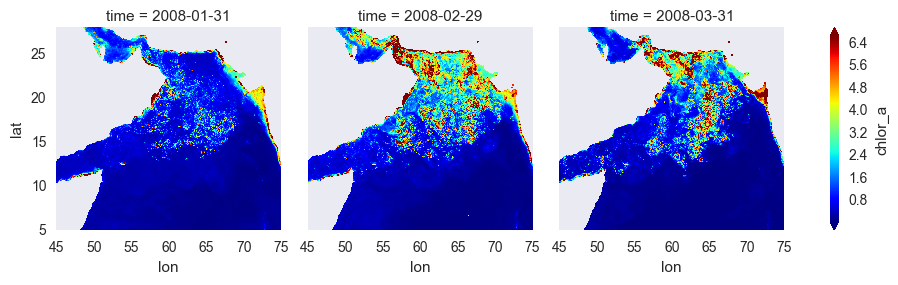

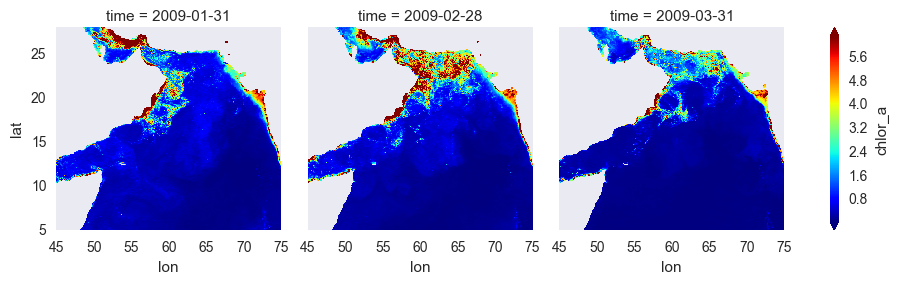

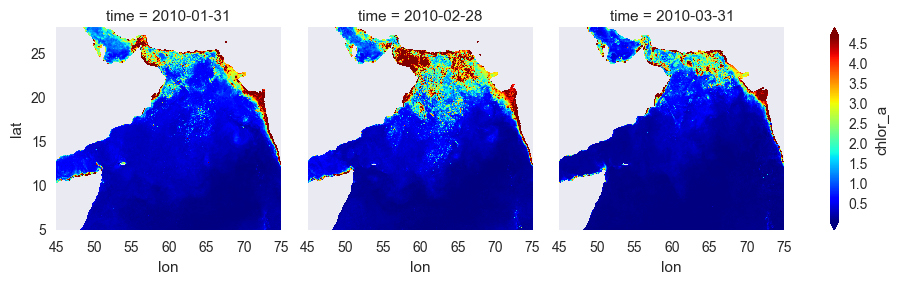

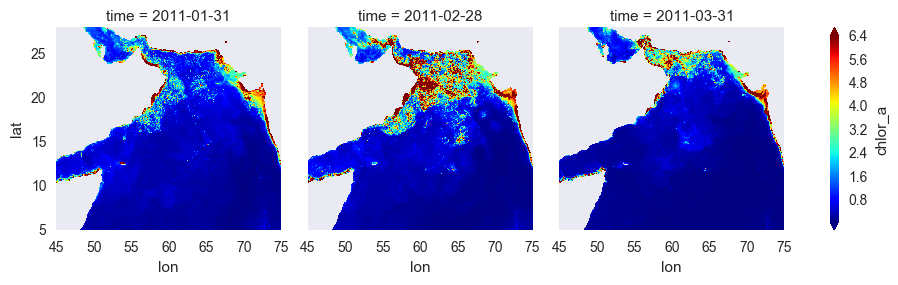

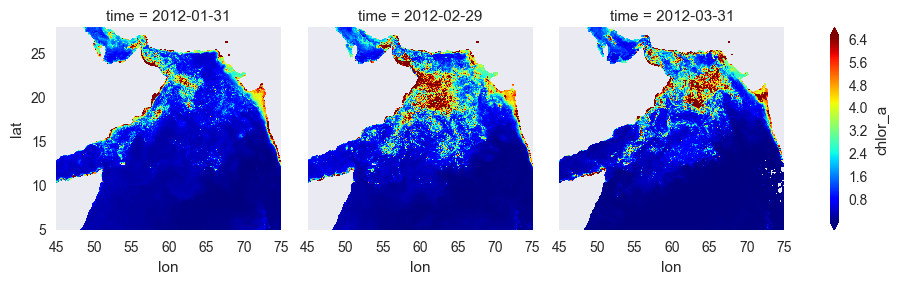

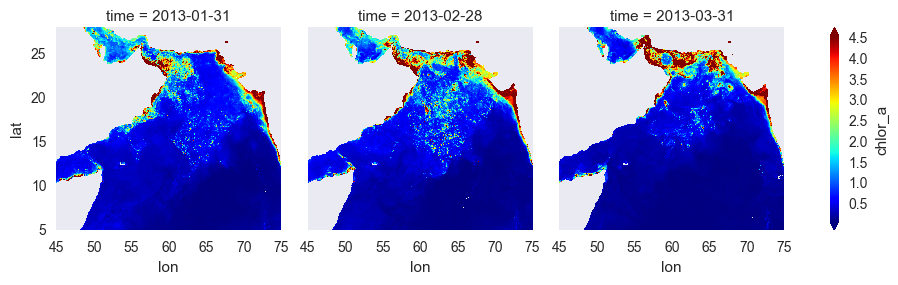

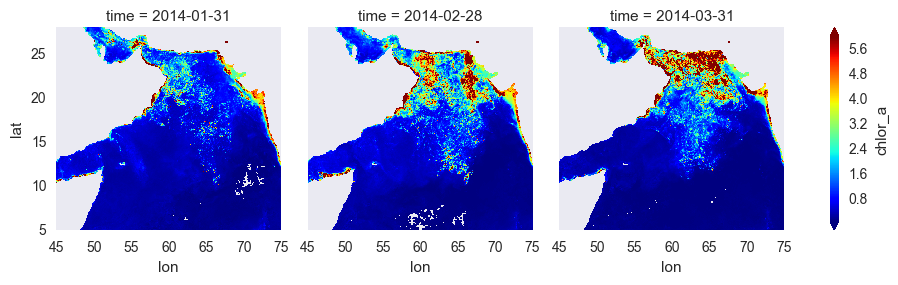

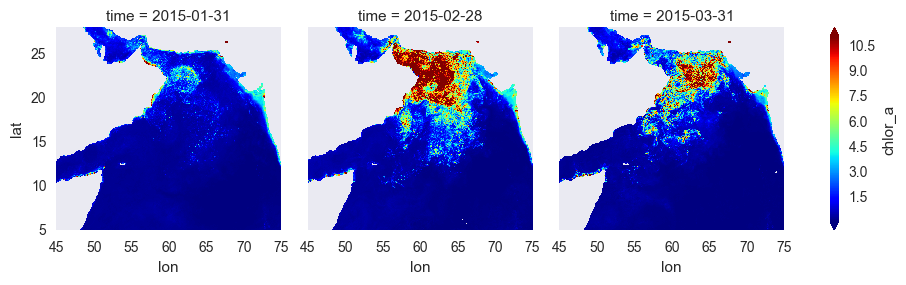

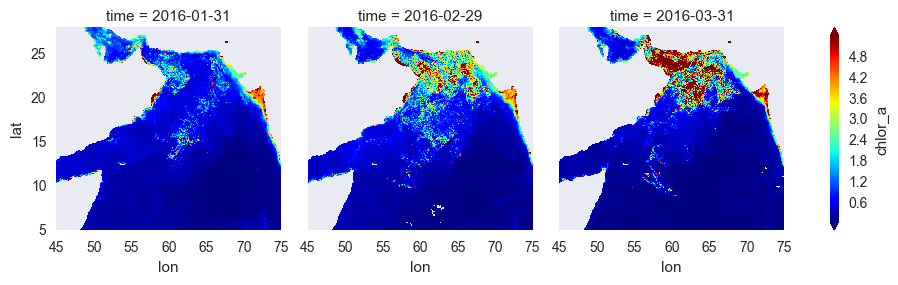

In [24]:
### Approach 2
### use xarray: http://xarray.pydata.org/en/stable/plotting.html
### gather the data, and plot
### norm=LogNorm() removed
### use robust (outlier not considered)
for year in range(2003, 2017):
    time_target = [np.datetime64(str(year) + '-02'), np.datetime64(str(year) + '-03'), np.datetime64(str(year) + '-04')]
    ds_resample.chlor_a.sel(time= list(time_target),  method='nearest').plot(x='lon', y='lat', col='time',  cmap="jet",  robust=True, col_wrap=3)
    
    

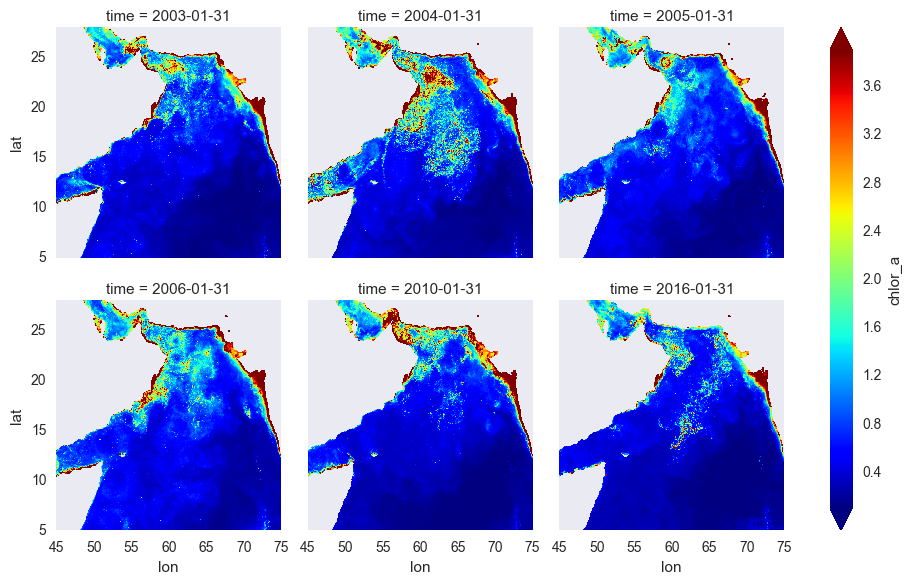

In [25]:
### Approach 3
### use xarray: http://xarray.pydata.org/en/stable/plotting.html
### focus on a particular month, and plot
### norm=LogNorm() removed
### use robust (outlier not considered)


time_target2 = [np.datetime64(str(year) + '-02') for year in np.array([2003, 2004,2005,2006,2010,2016])]
#time_target3 = [np.datetime64(str(year) + '-03') for year in range(2003, 2017)]
#time_target4 = [np.datetime64(str(year) + '-04') for year in range(2003, 2017)]

ds_resample.chlor_a.sel(time= list(time_target2),  method='nearest').plot(x='lon', y='lat', col='time',  cmap="jet",  robust=True, col_wrap=3)
